In [2]:
import os
import glob
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append("../../../")

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier, XGBRFClassifier

from helpers.split import label_strings, tag_label_feature_split

/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
def cross_gradient_boost_experiment(dataset):

    # load data and separate one hot encoded labels from features,
    # transform one hot encoded labels into label strings,
    # then encode label strings

    print(f"\n\nDataset: {dataset}\n")   
    
    df = pd.read_pickle(dataset)
    _, one_hot_labels, X = tag_label_feature_split(df)
    labels = label_strings(one_hot_labels)

    le = LabelEncoder()
    y = le.fit_transform(pd.Series.ravel(labels))

    # divide into train and test data sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=10, stratify=y
    )

    # standardize features
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    X_test_std = sc.transform(X_test)

    # calculate sample weights to deal with class imbalance
    sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
    model = XGBClassifier(
        use_label_encoder=False, 
        objective="multi:softprob", 
        eval_metric="mlogloss",
        tree_method='gpu_hist'
    )

    model.fit(X_train_std, y_train, sample_weight=sample_weights)

    predictions = model.predict(X_test_std)
    train_accuracy = model.score(X_train_std, y_train)
    test_accuracy = model.score(X_test_std, y_test)

    class_names = le.inverse_transform(list(model.classes_))
    print(f"Train: {train_accuracy = :f}\n")
    print(
        classification_report(
            y_train, model.predict(X_train_std), digits=4, target_names=class_names
        )
    )
    print(f"Test: {test_accuracy = :f}\n")
    print(
        classification_report(y_test, predictions, digits=4, target_names=class_names)
    )

    # generate confusion matrix and
    # display nicely with seaborn
    cm = confusion_matrix(y_test, predictions, normalize="true")
    heatmap_labels = list(le.classes_)
    plt.figure(figsize=(9, 9))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".3f",
        linewidths=0.5,
        square=True,
        cmap="Blues_r",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    name = os.path.basename(dataset).split(".")[0]
    plt.title(f"{name} test (row normalized)")
    plt.show()

    return model



Dataset: ../../../datasets/dataset_01_mean.pickle

Train: train_accuracy = 0.897892

                 precision    recall  f1-score   support

    genre_blues     0.9350    1.0000    0.9664       374
genre_classical     0.9492    0.9337    0.9414      4221
  genre_country     0.9211    1.0000    0.9589       327
    genre_disco     0.9003    1.0000    0.9475       289
   genre_hiphop     0.8512    0.9553    0.9003      1701
     genre_jazz     0.7907    0.9831    0.8764      1241
    genre_metal     0.9275    1.0000    0.9624       665
      genre_pop     0.9194    0.7824    0.8454      4274
   genre_reggae     0.8097    0.9987    0.8943       788
     genre_rock     0.8992    0.8638    0.8811      3200

       accuracy                         0.8979     17080
      macro avg     0.8903    0.9517    0.9174     17080
   weighted avg     0.9021    0.8979    0.8969     17080

Test: test_accuracy = 0.527745

                 precision    recall  f1-score   support

    genre_blues     0.

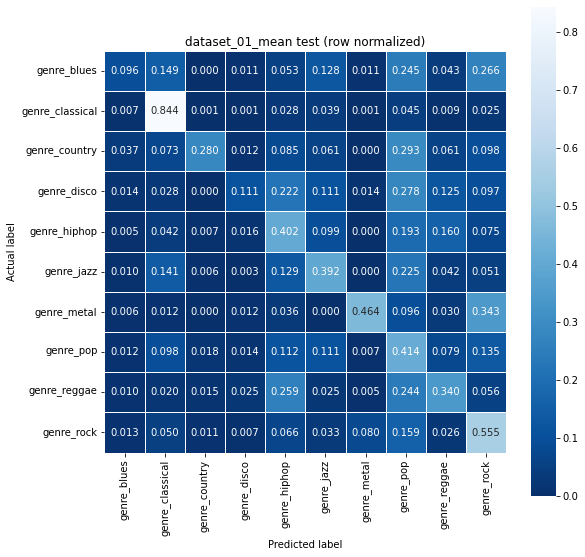



Dataset: ../../../datasets/dataset_02_mean_cov.pickle

Train: train_accuracy = 0.997073

                 precision    recall  f1-score   support

    genre_blues     0.9973    1.0000    0.9987       374
genre_classical     0.9988    0.9981    0.9985      4221
  genre_country     1.0000    1.0000    1.0000       327
    genre_disco     1.0000    1.0000    1.0000       289
   genre_hiphop     0.9982    1.0000    0.9991      1701
     genre_jazz     0.9968    0.9992    0.9980      1241
    genre_metal     1.0000    1.0000    1.0000       665
      genre_pop     0.9974    0.9920    0.9947      4274
   genre_reggae     0.9987    1.0000    0.9994       788
     genre_rock     0.9922    0.9978    0.9950      3200

       accuracy                         0.9971     17080
      macro avg     0.9980    0.9987    0.9983     17080
   weighted avg     0.9971    0.9971    0.9971     17080

Test: test_accuracy = 0.639663

                 precision    recall  f1-score   support

    genre_blues   

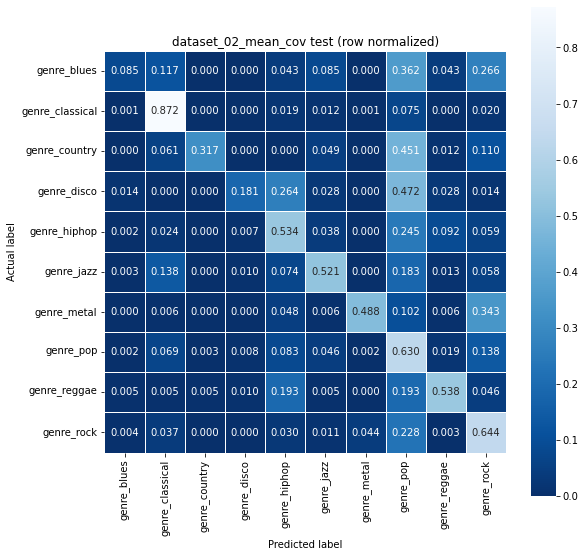



Dataset: ../../../datasets/dataset_03_mean_icov.pickle

Train: train_accuracy = 0.996136

                 precision    recall  f1-score   support

    genre_blues     0.9947    1.0000    0.9973       374
genre_classical     0.9906    0.9991    0.9948      4221
  genre_country     1.0000    1.0000    1.0000       327
    genre_disco     1.0000    1.0000    1.0000       289
   genre_hiphop     0.9971    1.0000    0.9985      1701
     genre_jazz     0.9968    0.9992    0.9980      1241
    genre_metal     1.0000    1.0000    1.0000       665
      genre_pop     0.9988    0.9878    0.9933      4274
   genre_reggae     1.0000    1.0000    1.0000       788
     genre_rock     0.9969    0.9972    0.9970      3200

       accuracy                         0.9961     17080
      macro avg     0.9975    0.9983    0.9979     17080
   weighted avg     0.9962    0.9961    0.9961     17080

Test: test_accuracy = 0.627956

                 precision    recall  f1-score   support

    genre_blues  

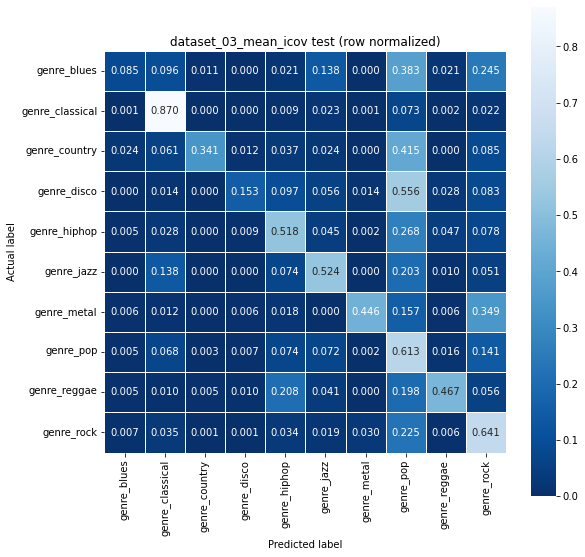



Dataset: ../../../datasets/dataset_04_mean_cov_icov.pickle

Train: train_accuracy = 0.999063

                 precision    recall  f1-score   support

    genre_blues     0.9973    1.0000    0.9987       374
genre_classical     0.9993    0.9995    0.9994      4221
  genre_country     1.0000    1.0000    1.0000       327
    genre_disco     1.0000    1.0000    1.0000       289
   genre_hiphop     0.9988    1.0000    0.9994      1701
     genre_jazz     1.0000    0.9992    0.9996      1241
    genre_metal     1.0000    1.0000    1.0000       665
      genre_pop     0.9995    0.9972    0.9984      4274
   genre_reggae     1.0000    1.0000    1.0000       788
     genre_rock     0.9975    0.9997    0.9986      3200

       accuracy                         0.9991     17080
      macro avg     0.9992    0.9996    0.9994     17080
   weighted avg     0.9991    0.9991    0.9991     17080

Test: test_accuracy = 0.645985

                 precision    recall  f1-score   support

    genre_blu

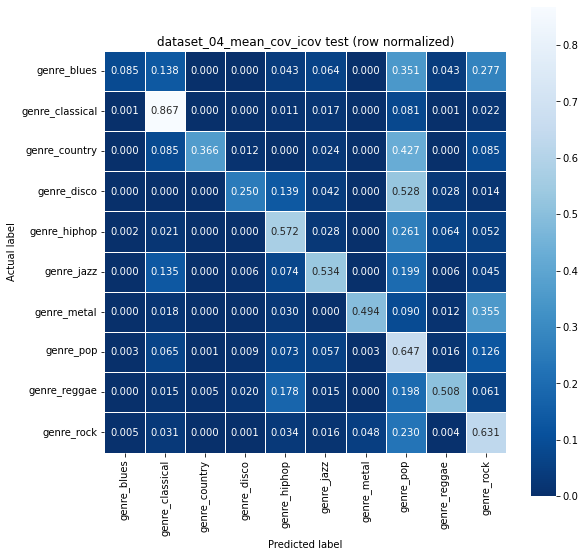



Dataset: ../../../datasets/dataset_05_pvtt.pickle

Train: train_accuracy = 0.815691

                 precision    recall  f1-score   support

    genre_blues     0.7633    1.0000    0.8657       374
genre_classical     0.9382    0.9067    0.9222      4221
  genre_country     0.6987    1.0000    0.8226       327
    genre_disco     0.7875    1.0000    0.8811       289
   genre_hiphop     0.7415    0.9071    0.8160      1701
     genre_jazz     0.6642    0.9484    0.7813      1241
    genre_metal     0.7858    0.9985    0.8795       665
      genre_pop     0.8755    0.6069    0.7169      4274
   genre_reggae     0.6530    0.9937    0.7881       788
     genre_rock     0.8359    0.7356    0.7826      3200

       accuracy                         0.8157     17080
      macro avg     0.7744    0.9097    0.8256     17080
   weighted avg     0.8338    0.8157    0.8121     17080

Test: test_accuracy = 0.506907

                 precision    recall  f1-score   support

    genre_blues     0.

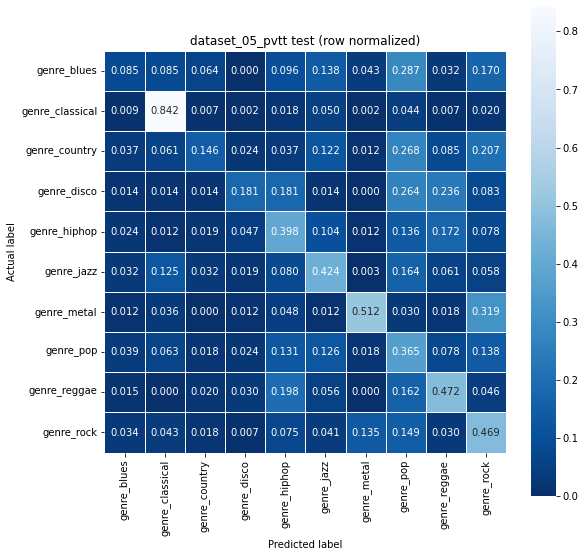



Dataset: ../../../datasets/dataset_06_pvtt_mean.pickle

Train: train_accuracy = 0.944028

                 precision    recall  f1-score   support

    genre_blues     0.9590    1.0000    0.9791       374
genre_classical     0.9811    0.9728    0.9769      4221
  genre_country     0.9761    1.0000    0.9879       327
    genre_disco     0.9764    1.0000    0.9880       289
   genre_hiphop     0.9113    0.9965    0.9520      1701
     genre_jazz     0.8639    0.9976    0.9260      1241
    genre_metal     0.9765    1.0000    0.9881       665
      genre_pop     0.9556    0.8570    0.9037      4274
   genre_reggae     0.9195    1.0000    0.9581       788
     genre_rock     0.9280    0.9309    0.9295      3200

       accuracy                         0.9440     17080
      macro avg     0.9447    0.9755    0.9589     17080
   weighted avg     0.9456    0.9440    0.9435     17080

Test: test_accuracy = 0.602903

                 precision    recall  f1-score   support

    genre_blues  

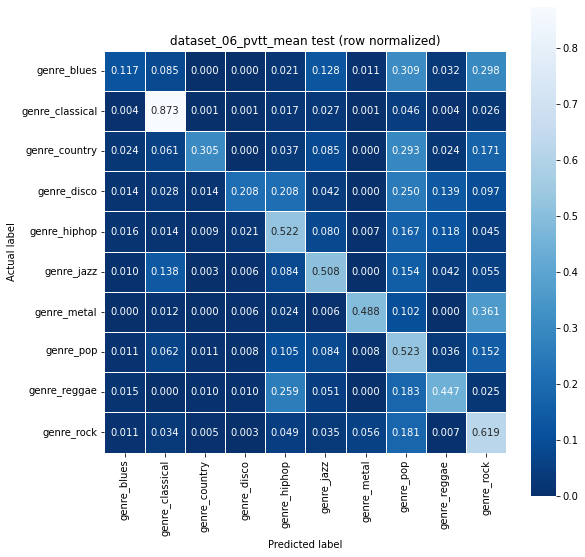



Dataset: ../../../datasets/dataset_07_pvtt_mean_cov.pickle

Train: train_accuracy = 0.998068

                 precision    recall  f1-score   support

    genre_blues     0.9973    1.0000    0.9987       374
genre_classical     0.9995    0.9993    0.9994      4221
  genre_country     1.0000    1.0000    1.0000       327
    genre_disco     1.0000    1.0000    1.0000       289
   genre_hiphop     0.9971    1.0000    0.9985      1701
     genre_jazz     0.9984    0.9992    0.9988      1241
    genre_metal     1.0000    1.0000    1.0000       665
      genre_pop     0.9993    0.9934    0.9964      4274
   genre_reggae     1.0000    1.0000    1.0000       788
     genre_rock     0.9938    0.9997    0.9967      3200

       accuracy                         0.9981     17080
      macro avg     0.9985    0.9992    0.9988     17080
   weighted avg     0.9981    0.9981    0.9981     17080

Test: test_accuracy = 0.658628

                 precision    recall  f1-score   support

    genre_blu

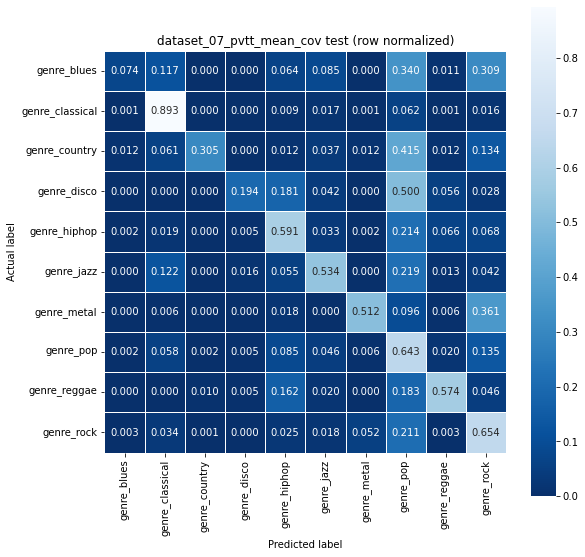



Dataset: ../../../datasets/dataset_08_pvtt_mean_icov.pickle

Train: train_accuracy = 0.997482

                 precision    recall  f1-score   support

    genre_blues     0.9973    1.0000    0.9987       374
genre_classical     0.9957    0.9991    0.9974      4221
  genre_country     1.0000    1.0000    1.0000       327
    genre_disco     1.0000    1.0000    1.0000       289
   genre_hiphop     0.9971    1.0000    0.9985      1701
     genre_jazz     0.9992    0.9992    0.9992      1241
    genre_metal     1.0000    1.0000    1.0000       665
      genre_pop     0.9986    0.9927    0.9957      4274
   genre_reggae     0.9987    1.0000    0.9994       788
     genre_rock     0.9966    0.9978    0.9972      3200

       accuracy                         0.9975     17080
      macro avg     0.9983    0.9989    0.9986     17080
   weighted avg     0.9975    0.9975    0.9975     17080

Test: test_accuracy = 0.653477

                 precision    recall  f1-score   support

    genre_bl

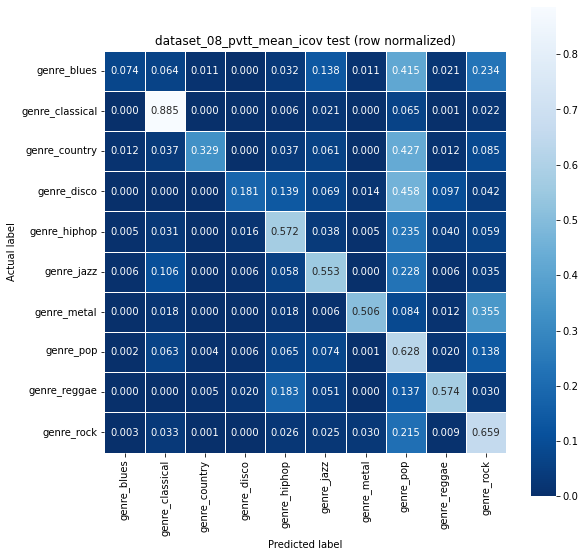



Dataset: ../../../datasets/dataset_09_pvtt_mean_cov_icov.pickle

Train: train_accuracy = 0.999297

                 precision    recall  f1-score   support

    genre_blues     1.0000    1.0000    1.0000       374
genre_classical     0.9995    0.9995    0.9995      4221
  genre_country     1.0000    1.0000    1.0000       327
    genre_disco     1.0000    1.0000    1.0000       289
   genre_hiphop     0.9988    1.0000    0.9994      1701
     genre_jazz     1.0000    1.0000    1.0000      1241
    genre_metal     1.0000    1.0000    1.0000       665
      genre_pop     0.9995    0.9979    0.9987      4274
   genre_reggae     1.0000    1.0000    1.0000       788
     genre_rock     0.9981    0.9997    0.9989      3200

       accuracy                         0.9993     17080
      macro avg     0.9996    0.9997    0.9997     17080
   weighted avg     0.9993    0.9993    0.9993     17080

Test: test_accuracy = 0.660267

                 precision    recall  f1-score   support

    genr

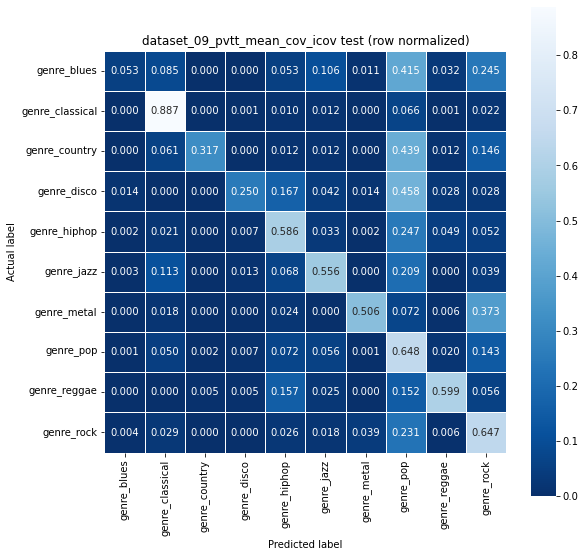

In [4]:
dataset_folder = "../../../datasets/"
datasets = sorted([name for name in glob.glob(dataset_folder + "*.pickle")])
for dataset in datasets:
 cross_gradient_boost_experiment(dataset)